In [1283]:
%matplotlib inline
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import feedparser as fp
import re
import pickle
from collections import Counter
from sklearn import feature_extraction, naive_bayes, neural_network, preprocessing, svm, model_selection, pipeline, decomposition, cluster

In [1284]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

f1=fp.parse('https://www.nyaa.se/?page=rss&cats=1_37&term=horri+01&filter=2').entries
f2=fp.parse('https://www.tokyotosho.info/rss.php?filter=1&entries=450').entries
f3=fp.parse('https://www.nyaa.se/?page=rss&cats=1_37&term=01+720&filter=2&minsize=0&maxsize=600').entries
f4=fp.parse('https://www.nyaa.se/?page=rss&cats=1_37&filter=2&maxsize=600').entries

In [1285]:
my="""[HorribleSubs] Drifters - 02 [720p].mkv
[HorribleSubs] Drifters - 01v2 [720p].mkv
[HorribleSubs] Shuumatsu no Izetta - 11 [720p].mkv
[HorribleSubs] Shuumatsu no Izetta - 08 [720p].mkv
[HorribleSubs] Shuumatsu no Izetta - 07 [720p].mkv
[HorribleSubs] Shuumatsu no Izetta - 10 [720p].mkv
[HorribleSubs] Shuumatsu no Izetta - 09 [720p].mkv
[IEgg] Fate／Kaleid Liner Prisma Illya Zwei! Character Song Prisma☆Love Parade Vol.2 (320K+BK).zip
[IEgg] Fate／Kaleid Liner Prisma Illya Zwei! Character Song Prisma☆Love Parade Vol.1 (320K+BK).zip
Discworld
[얼티메이트] [150128] TVアニメ「Fate／kaleid liner プリズマ☆イリヤ ツヴァイ！」キャラクターソング Prisma☆Love Parade Vol.3 (320K+BK)
[Nipponsei] Fate Kaleid Liner Prisma Illya Original Soundtrack.zip
[HorribleSubs] Fate Kaleid Liner PRISMA ILLYA 3rei!! - 11 [720p].mkv
[HorribleSubs] Fate Kaleid Liner PRISMA ILLYA 3rei!! - 12 [720p].mkv
[HorribleSubs] Show By Rock!! - 01 [720p].mkv
[HorribleSubs] Amanchu! - 07 [720p].mkv
[HorribleSubs] Amanchu! - 09 [720p].mkv
[HorribleSubs] Amanchu! - 08 [720p].mkv
[HorribleSubs] Amanchu! - 10 [720p].mkv
[SanKyuu] Hikaru no Go [BD 720p AAC]
Log_Horizon_v01-08-txt.zip
FELT
[Chihiro]_Occultic;Nine_-_01_[720p_Hi10P_AAC][A3A543B3].mkv
[CTSHiryuu] Brave Witches - 01 [720p H264 AAC][2B965D44].mkv
[HorribleSubs] Girlish Number - 01 [720p].mkv
[HorribleSubs] Brave Witches - 01 [720p].mkv
[HorribleSubs] Mahou Shoujo Ikusei Keikaku - 01 [720p].mkv
[HorribleSubs] Mob Psycho 100 - 01 [720p].mkv
[HorribleSubs] Shuumatsu no Izetta - 01 [720p].mkv""".split('\n')

In [1286]:
my_titles = pd.DataFrame([(' '.join(re.findall('[a-z]+|[0-9]+p',x.lower())),1) for x in my], columns=['text','class'])
#my_titles = pd.DataFrame([(x,1) for x in my], columns=['text','class'])

In [1287]:
ft=f1+f2+f3+f4
titles=pd.DataFrame([(' '.join(re.findall('[a-z]+|[0-9]+p',x['title'].lower())),0) for x in ft], columns=['text','class'])
#titles=pd.DataFrame([(x['title'],0) for x in ft], columns=['text','class'])


#titles.drop_duplicates(inplace=True)
#my_titles.drop_duplicates(inplace=True)

#titles.update(my_titles, join='left')

tot=titles[~titles['text'].isin(my_titles['text'])].dropna()
#tot=titles.select(lambda x: x not in my_titles['text'])
#tot = titles
tot = my_titles.append(tot)
#[x for x in tot['text'].values if x in my_titles['text'].values]
#tot = titles
#tot['class'] = tot['class'].astype('int64')
tot.reset_index(inplace=True, drop=True)
#tot.loc[tot.text.duplicated(), :]

In [1288]:
cvr=feature_extraction.text.CountVectorizer(ngram_range=(1,1))

In [1289]:
m=cvr.fit_transform(tot['text'].values)

In [1290]:
X=m.toarray()
r=tot['class'].values
X.shape

(423, 404)

In [1291]:
est = [
    ('cvr', feature_extraction.text.CountVectorizer(ngram_range=(1,1))), 
    ('pca', decomposition.TruncatedSVD(n_components=200)), 
    ('clf', neural_network.MLPClassifier(max_iter=2000, learning_rate='adaptive'))]
pip = pipeline.Pipeline(est)

In [1292]:
pd_comb = dict(
    clf__activation=['identity', 'logistic', 'tanh', 'relu'],
    clf__solver=['lbfgs','adam'],
    clf__hidden_layer_sizes=sc.stats.randint(1,50+1),
    pca__n_components=sc.stats.randint(1,50+1),
    #clf__beta_1=sc.stats.uniform(scale=1),
    #clf__beta_2=sc.stats.uniform(scale=1), 
    #clf__epsilon=sc.stats.expon(scale=1e-08),
    #clf__learning_rate_init=sc.stats.expon(scale=0.001),
    #clf__momentum=sc.stats.uniform(scale=1),
    #clf__power_t=sc.stats.expon(scale=0.5),
    #clf__tol=sc.stats.expon(scale=0.0001),
    #clf__validation_fraction=sc.stats.expon(scale=0.1),
    #cvr__min_df=[1,2,3],
    #cvr__max_df=sc.stats.uniform(scale=1),
    #cvr__ngram_range=[(1,x) for x in range(1,4+1)]
)

In [1293]:
rrclf = model_selection.RandomizedSearchCV(
    pip,
    pd_comb,
    error_score=0,
    cv=5,
    n_jobs=-1,
    verbose=1,
    n_iter=50)
rrclf.fit(tot['text'],r)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 223 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, error_score=0,
          estimator=Pipeline(steps=[('cvr', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
          fit_params={}, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'pca__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff561ba60f0>, 'clf__hidden_layer_sizes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff561ba6cf8>, 'clf__solver': ['lbfgs', 'adam'], 'clf__activation': ['identity', 'logistic', 'tanh', 'relu']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=1)

In [1294]:
cvrclf=rrclf.best_estimator_
rrclf.best_score_, rrclf.best_params_, #sum(rrclf.best_estimator_.named_steps['pca'].explained_variance_ratio_), sc.std(rrclf.cv_results_['mean_test_score'])

(0.94326241134751776,
 {'clf__activation': 'logistic',
  'clf__hidden_layer_sizes': 7,
  'clf__solver': 'lbfgs',
  'pca__n_components': 6})

In [1295]:
aczip = zip(['identity', 'logistic', 'tanh', 'relu'], list(range(4)))
acmap = {x:y for x,y in aczip}
acmap

{'identity': 0, 'logistic': 1, 'relu': 3, 'tanh': 2}

KeyError: 'param_cvr__ngram_range'

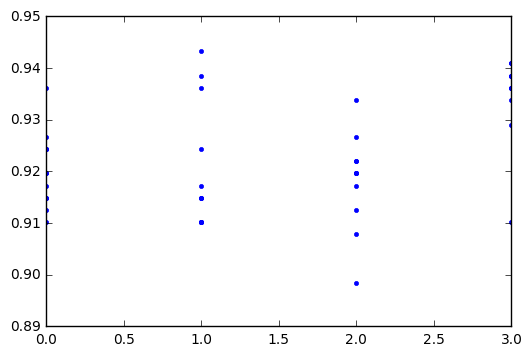

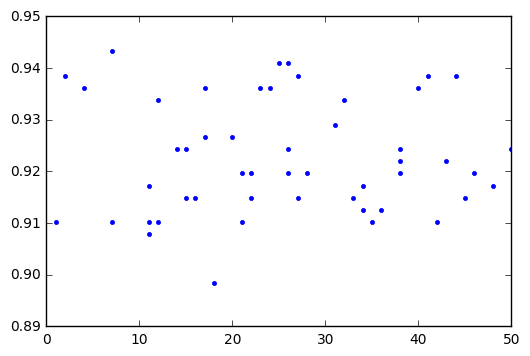

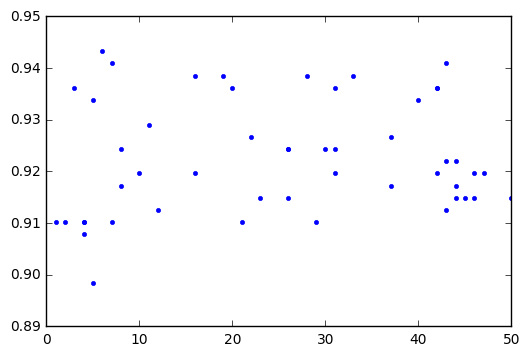

In [1296]:

plt.plot(list(int(acmap[x]) for x in rrclf.cv_results_['param_clf__activation']), rrclf.cv_results_['mean_test_score'], '.')
plt.figure()
plt.plot(list(int(x) for x in rrclf.cv_results_['param_clf__hidden_layer_sizes']), rrclf.cv_results_['mean_test_score'], '.')
plt.figure()
plt.plot(list(int(x) for x in rrclf.cv_results_['param_pca__n_components']), rrclf.cv_results_['mean_test_score'], '.')
plt.figure()
plt.plot(list(int(x[1]) for x in rrclf.cv_results_['param_cvr__ngram_range']), rrclf.cv_results_['mean_test_score'], '.')
#

In [1298]:
#kmeans
kpipe = pipeline.make_pipeline(feature_extraction.text.CountVectorizer(), cluster.KMeans(init='k-means++'))
kpara = dict(kmeans__n_clusters=sc.stats.randint(1,335+1))
rkp=model_selection.RandomizedSearchCV(kpipe, kpara, cv=5, n_jobs=-1, n_iter=100, verbose=1, error_score=0)
rkp.fit(tot['text'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished


RandomizedSearchCV(cv=5, error_score=0,
          estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))]),
          fit_params={}, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'kmeans__n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff561c4acf8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=1)

In [1331]:
rkp.best_score_, rkp.best_params_, rkp.best_estimator_, #list(rkp.cv_results_['param_kmeans__n_clusters'])
#rkp.best_estimator_.predict(['horriblesubs show by rock 720p mkv',])

(-108.25772261623327,
 {'kmeans__n_clusters': 207},
 Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
   ...7, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0))]))

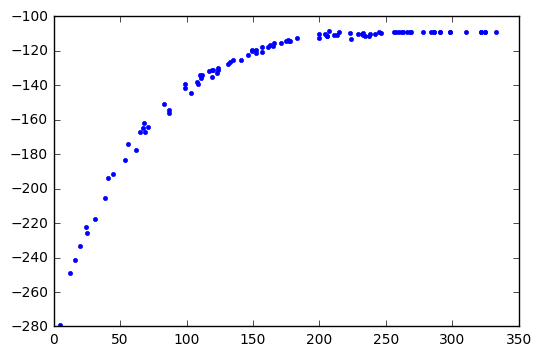

In [1300]:
plt.plot(list(rkp.cv_results_['param_kmeans__n_clusters']), rkp.cv_results_['mean_test_score'], '.')

pd0 = dict(activation=['identity', 'logistic', 'tanh', 'relu'], solver=['lbfgs','adam','sgd'], hidden_layer_sizes=[(10,),(30,)*2,(30,)*3,(30,)*4,(30,)*5,(20,),(50,),(100,)],alpha=sc.stats.expon(scale=1e-5), learning_rate_init=sc.stats.expon(scale=0.001))
pd1 = dict(beta_1=sc.stats.uniform(scale=1),
    beta_2=sc.stats.uniform(scale=1), 
     epsilon=sc.stats.expon(scale=1e-08),
     learning_rate_init=sc.stats.expon(scale=0.001),
     momentum=sc.stats.uniform(scale=1),
     power_t=sc.stats.expon(scale=0.5),
     tol=sc.stats.expon(scale=0.0001),
     validation_fraction=sc.stats.expon(scale=0.1)
          )
pd1.update(pd0)

pd = dict(activation=['identity', 'logistic', 'tanh', 'relu'],
          solver=['lbfgs','adam'],
          hidden_layer_sizes=[(25,)*x for x in range(1,7)]+[(250*x,) for x in range(1,4)]+[(1,)*100])

rclf = model_selection.RandomizedSearchCV(neural_network.MLPClassifier(max_iter=10000, learning_rate='adaptive'),
                                          pd, 
                                          cv=5, 
                                          n_jobs=-1,
                                          n_iter=10)
rclf.fit(X,r)

clfr=rclf.best_estimator_
rclf.best_params_, rclf.best_score_, rclf.cv_results_['mean_test_score']

with open('surprisingly_good_random_estimator.pkl', 'wb') as f:
    pickle.dump(rrclf.best_estimator_, f)

with open('best_random_estimator.pkl', 'rb') as f:
    clfb=pickle.load(f)

In [1301]:
res=model_selection.cross_val_score(cvrclf, tot['text'], r, cv=5)
(sc.mean(res), sc.std(res))

(0.90767507002801118, 0.04782640632679068)

In [1302]:
clf = neural_network.MLPClassifier(max_iter=2000)
nfeat=X.shape[1]
ncomp = int(nfeat*.9)
pipe = pipeline.make_pipeline(
    feature_extraction.text.CountVectorizer(ngram_range=(1,2)), 
    decomposition.TruncatedSVD(n_components=ncomp), 
    neural_network.MLPClassifier(hidden_layer_sizes=(ncomp//2,), max_iter=2000)
)
pipe.fit(tot['text'], r),clf.fit(X,r)

(Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 2), preprocessor=None, stop_words=None,
   ...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False))]),
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(100,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=2000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False))

In [1303]:
sum(pipe.named_steps['truncatedsvd'].explained_variance_ratio_), nfeat, ncomp

(0.99999999999999933, 404, 363)

In [1304]:
#clfr.score(X,r)
cvrclf.score(tot['text'],r), clf.score(X,r)

(0.95035460992907805, 0.99290780141843971)

In [1305]:
tx=[' '.join(re.findall('[a-z]+|[0-9]+p',x['title'].lower())) for x in f1+f2+f3+f4]
#tx=[x['title'] for x in ft]

#tx.append('sankyuu shuumatsu no izetta')

In [1306]:
m2 = cvr.transform(tx)

In [1307]:
X2 = m2.toarray()

In [1308]:
#pred=rclf.best_estimator_.predict(X2)
pred=cvrclf.predict(tx)
pred2=clf.predict(X2)
pred3=pipe.predict(tx)

In [1309]:
res=[x for i,x in enumerate(tx) if pred[i]==1]

In [1310]:
res1=[x for i,x in enumerate(tx) if x in list(my_titles['text'])]
#ress=pd.Series(tx)
#ress[~my_titles['text'].isin(ress)]
#ress.select(lambda x: x in my_titles['text'])

In [1311]:
res2=[x for i,x in enumerate(tx) if pred2[i]==1]

In [1312]:
res3=[x for i,x in enumerate(tx) if pred3[i]==1]

In [1313]:
[len([x for x in y if x not in res1]) for y in [res1, res, res2, res3]]

[0, 0, 1, 0]

In [1321]:
[x for x in res1 if x in res1]

['horriblesubs girlish number 720p mkv',
 'horriblesubs drifters v 720p mkv',
 'horriblesubs brave witches 720p mkv',
 'doremi sai chicchana mune no tokimeki s episode x mkv',
 'doremi sai chicchana mune no tokimeki s episode x e e e mkv',
 'ctshiryuu brave witches 720p h aac b d mkv',
 'horriblesubs girlish number 720p mkv',
 'horriblesubs drifters v 720p mkv',
 'horriblesubs brave witches 720p mkv',
 'horriblesubs mahou shoujo ikusei keikaku 720p mkv',
 'horriblesubs shuumatsu no izetta 720p mkv',
 'horriblesubs mob psycho 720p mkv',
 'horriblesubs mahou shoujo ikusei keikaku 720p mkv']

In [1315]:
pipe.predict_proba(['chihiro taboo tattoo 720p hi 10p aac e bbee'])

array([[ 0.9967298,  0.0032702]])

In [1316]:
ncomp=int(nfeat*.3)
nhid=1000#int(ncomp/2)
pipe2 = pipeline.make_pipeline(
    feature_extraction.text.CountVectorizer(ngram_range=(1,2)), 
    #decomposition.TruncatedSVD(n_components=ncomp)
)
pnn = neural_network.MLPClassifier(hidden_layer_sizes=(nhid,), max_iter=2000)
X3 = pipe2.fit_transform(tot['text'])
#pnn.partial_fit(X,r, classes=sc.unique(r))
pnn.fit(X3,r), nfeat, ncomp, nhid

(MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(1000,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=2000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False), 404, 121, 1000)

In [1317]:
pred3=pnn.predict(pipe2.transform(tx))
res3=[x for i,x in enumerate(tx) if pred3[i]==1 and x not in res1]
res3, len(res3)

(['chihiro occultic nine 720p hi 10p aac a a b',
  'horriblesubs show by rock s 720p mkv',
  'horriblesubs show by rock s 720p mkv'],
 3)

In [1318]:
#err = ['kaze no matasaburou 720p orphan',]
#err = ['pyon chiba pedal 720p mkv',]
err = ['chihiro taboo tattoo 720p hi 10p aac e bbee',]
#err = ['horriblesubs brave witches 480p mkv',]
#err = ['horriblesubs girlish number 1080p mkv',]
#err = ['horriblesubs show by rock s 480p mkv',]
#err = ['horriblesubs mahou shoujo nante mou ii desukara s 720p mkv',]
n = 0
while pnn.predict(pipe2.transform(err))[0] == 1 and n < 100:
    n += 1
    pnn.partial_fit(pipe2.transform(err),[0,]*len(err))
    print(pnn.predict_proba(pipe2.transform(err)))
print(pnn.predict(pipe2.transform(err))[0])

0


In [1319]:
pred3=pnn.predict(pipe2.transform(tx))
res3=[x for i,x in enumerate(tx) if pred3[i]==1 and x not in res1]
res3, len([x for i,x in enumerate(tx) if pred3[i]==1 and x in res1])/len(res1), len(res3)

(['chihiro occultic nine 720p hi 10p aac a a b',
  'horriblesubs show by rock s 720p mkv',
  'horriblesubs show by rock s 720p mkv'],
 1.0,
 3)